# Shape metrics for stochastic neural representations

This notebook demonstrates how to compute shape metrics for stochastic neural network representations (described in Duong, Zhou et al., 2023; [arXiv:2211.11665](https://arxiv.org/abs/2211.11665)). Methods described here are stochastic generalizations of the deterministic shape metrics proposed by Williams et al. (2021; [arXiv:2210.14739](https://arxiv.org/abs/2110.14739)).



In [1]:
import itertools
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split

import netrep

## Create synthetic neural responses

We'll create $K=3$ example network representations to $M=4$ stimuli (each with rougly $r=250$ repeats), where each representation has dimensionality $N=2$.
We'll also make Networks 1 and 2 identically distribted, differing only by some arbitrary rotation.

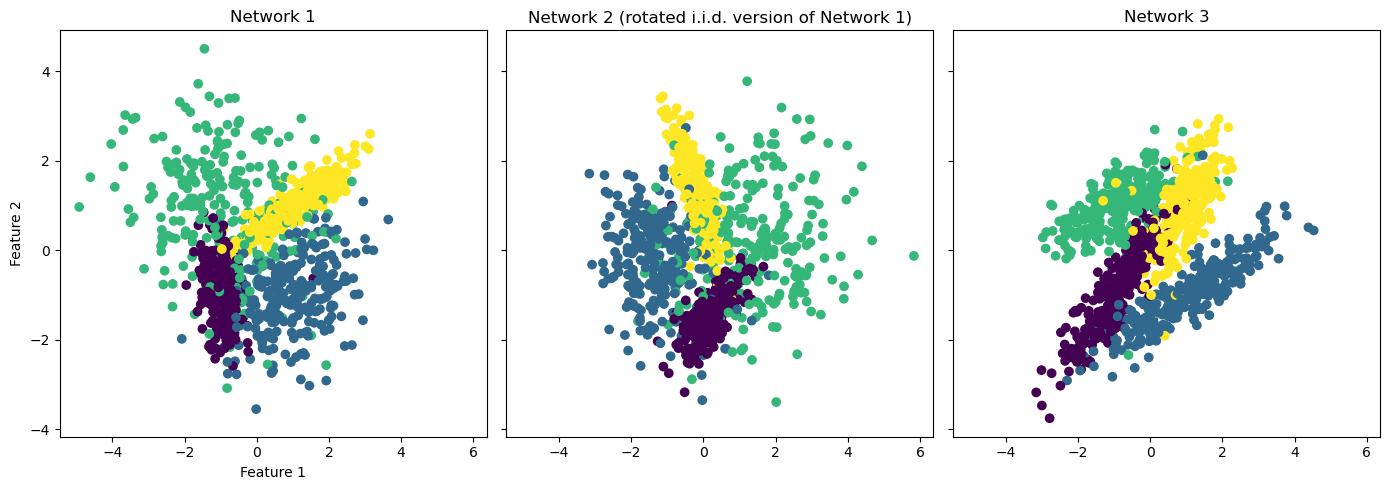

In [2]:
seed = 42069
n_samples = 2048
n_classes = 4  # Number of stimuli M
n_features = 2  # Dimensionality of responses N

rng = np.random.default_rng(seed)

_X, _y = sklearn.datasets.make_classification(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_features, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=n_classes, 
    n_clusters_per_class=1,
    random_state=seed,
 )

# Split _X and _y into two disjoint sets (X1, y) and (X2, y2)
X1, X2, y1, y2 = train_test_split(_X, _y, test_size=0.5, random_state=seed, shuffle=True, stratify=None)

# Randomly rotate X2
Q, _ = np.linalg.qr(rng.standard_normal((2, 2)))
X2 = X2 @ Q.T

# Create different set of neural responses
X3, y3 = sklearn.datasets.make_classification(
    n_samples=n_samples//2, 
    n_features=n_features, 
    n_informative=n_features, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=n_classes, 
    n_clusters_per_class=1,
    random_state=420,
 )

X = (X1, X2, X3)
y = (y1, y2, y3)

# Plot them
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharex="all", sharey="all")
ax[0].scatter(*X1.T, c=y1)
ax[1].scatter(*X2.T, c=y2)
ax[2].scatter(*X3.T, c=y3)

ax[0].set(title="Network 1", xlabel="Feature 1", ylabel="Feature 2")
ax[1].set(title="Network 2 (rotated i.i.d. version of Network 1)")
ax[2].set(title="Network 3")
fig.tight_layout()

## Gaussian 2-Wasserstein distance

To compute the stochastic shape distance between these three networks, we will first use a ground metric based on the 2-Wasserstein distance between two multivariate Gaussians (see Duong, Zhou et al., 2023; [arXiv:2211.11665](https://arxiv.org/abs/2211.11665) for more details).
The $\mathcal{W}_2^\alpha$ ground metric assumes you have an $N$-dimensional mean and an $N \times N$ covariance matrices for each of the $M$ classes. 

The hyper-parameter $\alpha \in [0, 2]$ linearly intepolates between a covariance-only distance when $\alpha=0$, and means-only distance $\alpha=2$.
The case when $\alpha=1$ is simply the standard $\mathcal{W}_2$ Wasserstein distance between two Gaussians.
When $\alpha=2$, this reduces to the deterministic shape distance proposed in Williams et al. 2021.

For two network responses `i` and `j`, `GaussianStochasticMetric.fit(Xi, Xj)` expects a list of class-conditional means and covariances for each class. 
`Xi` is a list or tuple of `[means_i, covs_i]` where `means_i` is an $M \times N$ array of condition means, and `covs_i` is an $M \times N \times N$ array of corresponding covariances.
`Xj` should have the same condition ordering as `Xi`.


### Preparing data for `GaussianStochasticMetric()`

In [3]:
from netrep.metrics.stochastic import GaussianStochasticMetric

def get_means_and_covs(
    X: npt.NDArray[np.float64], 
    y: [npt.NDArray[np.int64]],
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Helper method that computes class-conditional means and covariances."""
    
    classes = np.unique(y)
    K = len(classes)
    means = np.stack([np.mean(X[y==k], 0) for k in range(K)], 0)
    covs = np.stack([np.cov(X[y==k].T) for k in range(K)], 0)
    return means, covs

# compute the class-conditional means and covariances for each network
means_x1, covs_x1 = get_means_and_covs(X1, y1)
means_x2, covs_x2 = get_means_and_covs(X2, y2)
means_x3, covs_x3 = get_means_and_covs(X3, y3)

print("(means_x1.shape, covs_x2.shape)", (means_x1.shape, covs_x1.shape))

# compile into mu and sigma dicts for easier processing
means = (means_x1, means_x2, means_x3)
covs = (covs_x1, covs_x2, covs_x3)

(means_x1.shape, covs_x2.shape) ((4, 2), (4, 2, 2))


### Computing $\mathcal{W}_2^\alpha$ distances

Since Network 1 and 2's responses are iid up to some random rotation, we should expect the distances between Networks 1 vs 2 to be closer than 1 vs. 3 and 2 vs. 3.
Below, we compute the $\mathcal{W_2^\alpha}$ distance for $\alpha \in [0, 1, 2]$.

In [4]:
distmats_w2 = dict()

# compute Wasserstein ground metric for alpha=(0, 1, 2)
for alpha in (0, 1, 2):
    distmat_w2 = np.zeros((3, 3))
    metric = GaussianStochasticMetric(alpha)
    for i,j in itertools.combinations(range(3), 2):
        
        # the fit method expects a list [means, covs]
        Xi = (means[i], covs[i])
        Xj = (means[j], covs[j])
        metric.fit(Xi, Xj)
        distmat_w2[i,j] = metric.score(Xi, Xj)

    # dist matrix is symmetric
    distmat_w2 += distmat_w2.T
    distmats_w2[alpha] = distmat_w2

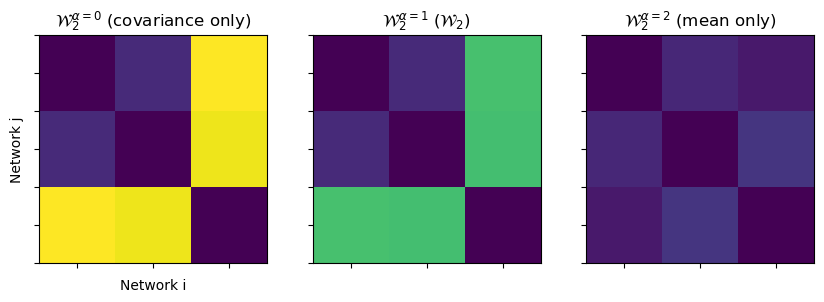

In [5]:
# plot the distmats
titles = [r"$\mathcal{W}_2^{\alpha=0}$" " (covariance only)",
          r"$\mathcal{W}_2^{\alpha=1}$" " ($\mathcal{W}_2$)",
          r"$\mathcal{W}_2^{\alpha=2}$" " (mean only)"]

# All heatmaps share same colorbar limits
_VMAX = max([distmats_w2[k].max() for k in distmats_w2])
_VMIN = min([distmats_w2[k].min() for k in distmats_w2])

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex="all", sharey="all")

for i, a in enumerate(distmats_w2.keys()):
    im = ax[i].imshow(distmats_w2[a], vmin=_VMIN, vmax=_VMAX)
    ax[i].set(title=titles[i])
ax[0].set(xticklabels=[], yticklabels=[], xlabel="Network i", ylabel="Network j");
# plt.colorbar()

The plotted distance matrices prominently how Networks 1 and 2 are closer as measured by our metrics -- particularly for $\alpha=0$ (covariance distance) and $\alpha=1$ (2-Wasserstein distance).
When $\alpha=2$, we discard the information about the covariance and compute distance using only the class-conditional means. 
In this case, the underlying similarities between Networks 1 and 2 are no longer apparent.

## Energy distance

When neural representations are not adequately described by a Gaussian, we provide Energy distance, $\mathcal{E}$, as a non-parametric alternative to the $\alpha$-interpolated 2-Wasserstein ground metric. 
See the paper for more details.

In [6]:
from netrep.metrics.stochastic import EnergyStochasticMetric

### Preparing data for `EnergyStochasticMetric()`

For $K$ networks with $N$-dimensional neural responses to $M$ conditions (e.g. images), each repeated $r$ times.
The `EnergyStochasticMetric()` object's fit method expects a numpy array of size $M \times r \times N$.
We can simply reshape the synthetic data that we created above.

In [7]:
def reshape_data(
    X: npt.NDArray[np.float64], 
    y: npt.NDArray[np.int64], 
    samples_per_class: int,
    ) -> npt.NDArray[np.float64]:
    """Helper method to reshape data for EnergyStochasticMetric()."""
    
    M = len(np.unique(y))  # number of classes
    X0 = [X[y==i] for i in range(M)]
    
    X0 = np.stack([x[:samples_per_class] for x in X0], 0)
    return X0

### Computing Energy distance

The fit method expects both arrays `Xi` and `Xj` to have the same shape.

In [8]:
distmat_energy = np.zeros((3, 3))
metric = EnergyStochasticMetric()
samples_per_class = 225

for i,j in itertools.combinations(range(3), 2):

    # the energy distance fit method expects M x r x N arrays
    Xi = reshape_data(X[i], y[i], samples_per_class)
    Xj =  reshape_data(X[j], y[j], samples_per_class)
    metric.fit(Xi, Xj)
    distmat_energy[i,j] = metric.score(Xi, Xj)

print(Xi.shape)
# dist matrix is symmetric
distmat_energy += distmat_energy.T

(4, 225, 2)


Below, we again see that the energy distance also captures how Networks 1 vs 2 are closer to each other than 1 vs. 3 and 2 vs. 3.

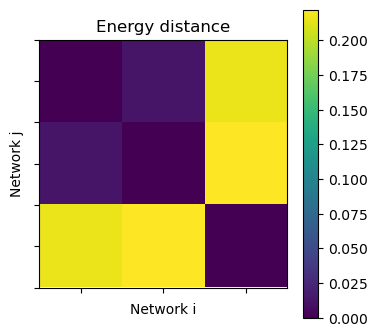

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(distmat_energy)
ax.set(title="Energy distance", xticklabels=[], yticklabels=[], xlabel="Network i", ylabel="Network j")
plt.colorbar(im);